# Artificial Neural Networks and Deep Learning



---



## Homework 1



To make your first submission, follow these steps:

1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.

2. Upload the `training_set.npz` file to this folder.

3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.

4. Load and process the data.

5. Implement and train your model.

6. Submit the generated `.zip` file to Codabench.

In [1]:
# from google.colab import drive



# drive.mount('/gdrive')

# %cd /gdrive/My Drive/Colab Notebooks/AN2DL/ShareFolder/Models/ResNet50 - Irene

# directory of my folder in google drive

## ⚙️ Import Libraries

In [2]:
seed = 85 # random variable to make the code reproducible



# Import necessary libraries

import os



# Set environment variables before importing modules

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'



# Suppress warnings

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=Warning)



# Import necessary modules

import numpy as np

import hashlib

import logging

import random



# Set seeds for random number generators in NumPy and Python

np.random.seed(seed)

random.seed(seed)



# Import TensorFlow and Keras

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl



# Set seed for TensorFlow

tf.random.set_seed(seed)

tf.compat.v1.set_random_seed(seed)



# Reduce TensorFlow verbosity

tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



# Print TensorFlow version

print(tf.__version__)



# Import other libraries

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

from PIL import Image

import matplotlib.gridspec as gridspec



# Configure plot display settings

sns.set(font_scale=1.4)

sns.set_style('white')

plt.rc('font', size=14)

%matplotlib inline

2.16.1


## ⏳ Load the Data

In [3]:
data = np.load('/kaggle/input/dataset-clean/training_set_cleaned.npz') # load the blood cells dataset into a variable called 'data'

print(data.files)

# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [4]:
# Define a mapping of labels to their corresponding digit names

classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes

# Save unique labels

unique_labels = list(classes.values())

In [5]:
# splitting between images and labels

X = data['images']

y = data['labels']

print(X.shape)
print(y.shape)
print(X.min(), X.max())

(11353, 96, 96, 3)
(11353, 1)
0 255


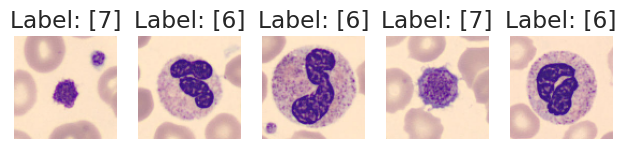

In [6]:
for i in range(5):

    plt.subplot(1, 5, i + 1)  # Arrange plots in a single row

    plt.imshow(X[i], cmap='gray', vmin=0, vmax=255)

    plt.title(f"Label: {y[i]}")

    plt.axis('off')  # Remove axes for better visibility



plt.tight_layout()

plt.show()

# Train and test set

In [7]:
# keeping 80% for the training set and 20% for the validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



print("Train:", X_train.shape, y_train.shape)

print("Validation:", X_val.shape, y_val.shape)

Train: (9082, 96, 96, 3) (9082, 1)
Validation: (2271, 96, 96, 3) (2271, 1)


## Data Balancing

In [8]:
# compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())

class_weight_dict = dict(zip(np.unique(y_train), class_weights))

class_weight_dict

{0: 1.733206106870229,
 1: 0.6741389548693587,
 2: 1.3827649208282582,
 3: 0.8214544138929089,
 4: 1.6918777943368106,
 5: 1.5403663500678426,
 6: 0.6227372462973121,
 7: 0.8672650878533231}

In [9]:
# Convert labels to categorical format using one-hot encoding

y_train = y_train.flatten()

y_val = y_val.flatten()

y_train

array([0, 6, 5, ..., 7, 1, 6], dtype=uint8)

## Network Parameters

In [10]:
input_shape = (96,96,3) # input shape our dataset

output_shape = len(np.unique(y_train)) # output shape: 8 classes

print("Input Shape:", input_shape)

print("Output Shape:", output_shape)



# it makes sense because the input shape is the dimension of the image and 3 channels

# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [11]:
epochs = 100 # epochs

batch_size = 64 # batch

learning_rate = 0.0001 # step size for updating the model's weights

In [12]:
# early stopping

patience = 10

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

In [13]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an exponential decay schedule to go from 0.01 to 0.00001
initial_learning_rate = 0.0001
final_learning_rate = 0.00001
steps_per_epoch = X_train.shape[0]/batch_size  # dataset size / batch size

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch * 10,  # Decay over 10 epochs (for example)
    decay_rate=(final_learning_rate / initial_learning_rate) ** (1 / (steps_per_epoch * 10)),  # Adjust decay rate
    staircase=False  # Decay smoothly, not in steps
)

In [14]:
augmentations = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),  # Rotate by 20%
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways
    #tf.keras.layers.RandomZoom(0.1),  # Zoom in/out
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift horizontally/vertically
    #tf.keras.layers.RandomBrightness(0.4, value_range=(0,255)),  # Brightness adjustment
    #tf.keras.layers.RandomContrast(0.4)  # Contrast adjustment
])

In [16]:
augmentations_new = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),  # Rotate by 20%
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways
    tf.keras.layers.RandomZoom(0.1),  # Zoom in/out
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift horizontally/vertically
    tf.keras.layers.RandomBrightness(0.4, value_range=(0,255)),  # Brightness adjustment
    tf.keras.layers.RandomContrast(0.4),  # Contrast adjustment
    tf.keras.layers.GaussianNoise(0.2)
])

## 🛠️ Train and Save the Model - ResNet50

In [18]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dropout, Dense

from tensorflow.keras.applications.resnet50 import preprocess_input

# RETE PRE ADDESTRATA

model = ResNet50(

    input_shape=input_shape,

    include_top=False, # in pratica sto togliendo il dense layer per risolvere un mio task enon la classificazione

    weights='imagenet',

    pooling = 'avg'

)


# Freeze all layers in InceptionV3 to use it solely as a feature extractor

model.trainable = False



# input layer

inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

x = augmentations(inputs)

x = preprocess_input(x)

# Uso lo strato della rete

x = model(x)


# Strato denso finale per la classificazione (output)
x = tfkl.Dense(512, activation='relu')(x)

x = tfkl.Dropout(0.5, name='dropout1')(x)

x = tfkl.Dense(256, activation='relu')(x)

x = tfkl.Dropout(0.5, name='dropout2')(x)



outputs = tfkl.Dense(8, activation='softmax', name='denseo')(x)



# Create a Model connecting input and output

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')



# Compile the model with Categorical Cross-Entropy loss and Adam optimizer

model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(),

              optimizer=tfk.optimizers.Lion(learning_rate = learning_rate),

              metrics=['accuracy'])

# Display a summary of the model architecture
model.summary(expand_nested=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 96, 96, 3) │          0 │ -                 │
│ random_rotation     │                   │            │                   │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ random_flip    │ (None, 96, 96, 3) │          0 │ -                 │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └                │ (None, 96, 96, 3) │          0 │ -                 │
│ random_translation  │                   │            │                   │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 96, 96)    │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 96, 96)    │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 96, 96)    │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 96, 96, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 96, 96, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ input_layer    │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ conv1_pad      │ (None, 102, 102,  │          0 │ -                 │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ conv1_conv     │ (None, 48, 48,    │      9,472 │ -                 │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ conv1_bn       │ (None, 48, 48,    │        256 │ -                 │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ conv1_relu     │ (None, 48, 48,    │          0 │ -                 │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,770,184 (94.49 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
# Train the model

history = model.fit(

    x=X_train,

    y=y_train,

    batch_size=batch_size,

    epochs=epochs,

    class_weight=class_weight_dict,

    validation_data=(X_val, y_val),

    callbacks=callbacks

).history



# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file, including final accuracy in the filename

model.save('TL_ResNet50.keras')

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.3158 - loss: 2.5446 - val_accuracy: 0.7164 - val_loss: 0.8320
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6768 - loss: 0.9102 - val_accuracy: 0.7710 - val_loss: 0.6476
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7501 - loss: 0.7304 - val_accuracy: 0.7917 - val_loss: 0.5754
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7689 - loss: 0.6645 - val_accuracy: 0.8173 - val_loss: 0.5203
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.7998 - loss: 0.5917 - val_accuracy: 0.8507 - val_loss: 0.4326
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8040 - loss: 0.5633 - val_accuracy: 0.8362 - val_loss: 0.4642
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8204 - loss: 0.5538 - val_accuracy: 0.8428 - val_loss: 0.4727
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8263 - loss: 0.50

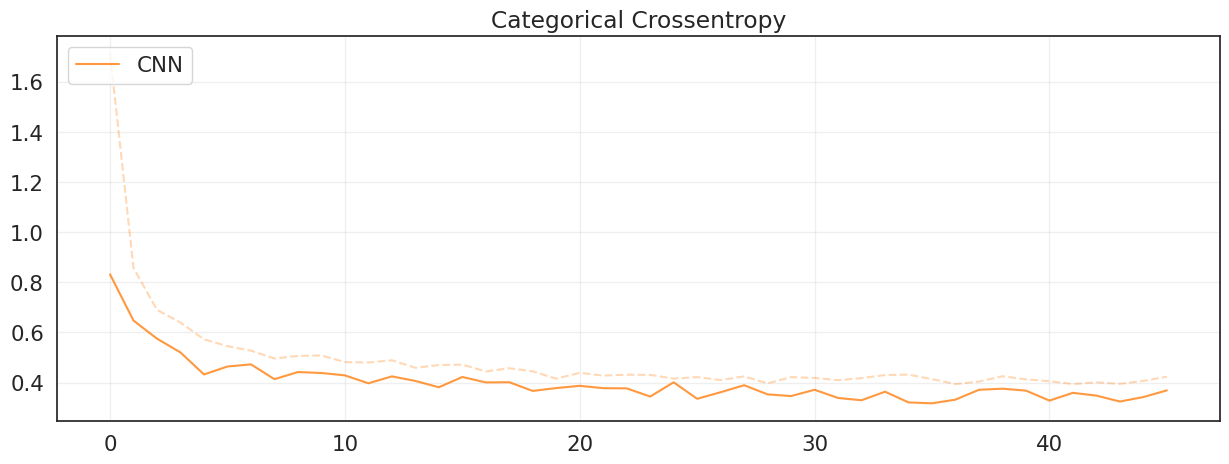

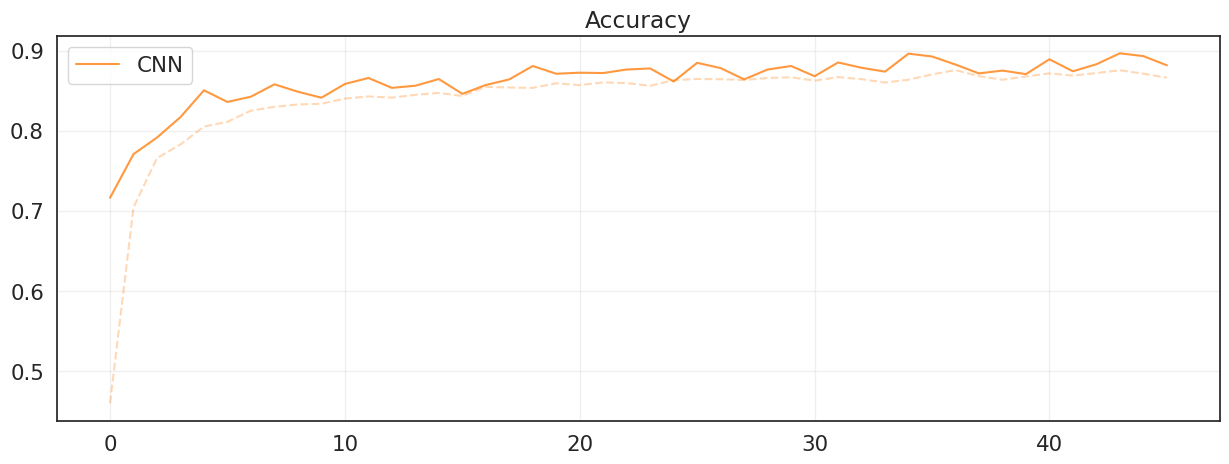

In [20]:
# Plot the training

plt.figure(figsize=(15,5))

plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history['val_loss'], label='CNN', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Categorical Crossentropy')

plt.grid(alpha=.3)



plt.figure(figsize=(15,5))

plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Accuracy')

plt.grid(alpha=.3)

In [21]:
y_prob = model.predict(X_val)
y_pred = y_prob.argmax(axis=1)
y_pred

71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


array([4, 3, 6, ..., 3, 6, 1])

### Validation set metrics

Accuracy: 0.8930
F1 Score: 0.8938

Classification Report:
               precision    recall  f1-score   support

           0     0.7281    0.9753    0.8338       162
           1     0.9039    0.9541    0.9283       414
           2     0.9254    0.9214    0.9234       229
           3     0.7674    0.8130    0.7895       353
           4     0.9571    0.8171    0.8816       164
           5     0.8831    0.7684    0.8218       177
           6     0.9752    0.8621    0.9152       457
           7     0.9874    0.9937    0.9905       315

    accuracy                         0.8930      2271
   macro avg     0.8910    0.8881    0.8855      2271
weighted avg     0.9005    0.8930    0.8938      2271



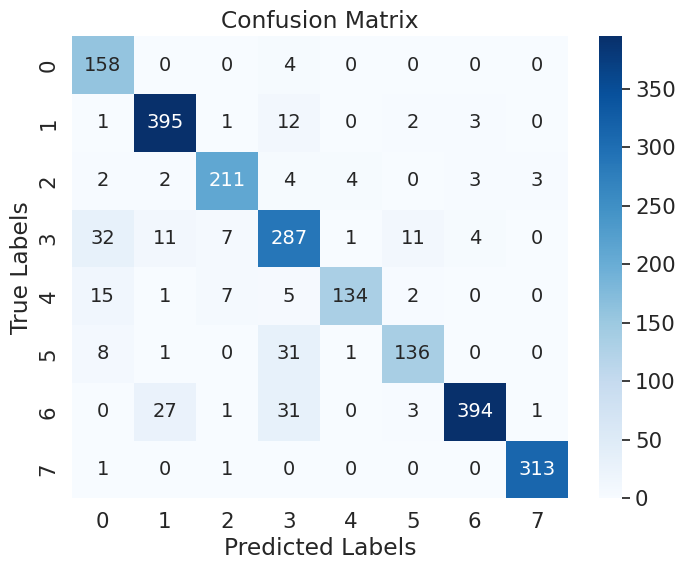

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



# Calculate metrics

accuracy = accuracy_score(y_val, y_pred)

f1 = f1_score(y_val, y_pred, average='weighted')



# Print the results

print(f"Accuracy: {accuracy:.4f}")

print(f"F1 Score: {f1:.4f}")



# Detailed per-class metrics

print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))



# Compute confusion matrix

cm = confusion_matrix(y_val, y_pred)



# Create a heatmap for the confusion matrix

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))

plt.title('Confusion Matrix')

plt.xlabel('Predicted Labels')

plt.ylabel('True Labels')



# Display the plot

plt.show()

In [23]:
unique, counts = np.unique(y_train, return_counts=True)

print("Distribuzione delle classi nei dati di training:", dict(zip(unique, counts)))

Distribuzione delle classi nei dati di training: {0: 655, 1: 1684, 2: 821, 3: 1382, 4: 671, 5: 737, 6: 1823, 7: 1309}


In [24]:
%%writefile model.py

import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl





class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('TL_ResNet50.keras')



    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.



        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X)

        if len(preds.shape) == 2:

            preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


In [25]:
import os

from datetime import datetime



# Definisci il nome del file di output con timestamp

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'



# Crea una directory per il salvataggio del modello e dello script (se non esiste già)

output_dir = '/kaggle/working/'  # Directory di lavoro di Kaggle

if not os.path.exists(output_dir):

    os.makedirs(output_dir)



# Aggiungi i file alla compressione zip

os.system(f'zip -r {output_dir}{filename} model.py TL_ResNet50.keras')



# Ora il file .zip è pronto nella directory '/kaggle/working/'

print(f"File salvato come {output_dir}{filename}")

  adding: model.py (deflated 56%)
  adding: TL_ResNet50.keras (deflated 8%)
File salvato come /kaggle/working/submission_241121_104257.zip
